# EDA: анализ статистик по частям речи и тематическое моделирование

In [43]:
# импорт библиотек

# работа с данными
import numpy as np
import pandas as pd

# предобработка данных
import spacy
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from data_preproc.src.utils import preprocess_text5

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# понижение размерности
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# тематическое моделирование
from gensim import models
from gensim import corpora

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

In [3]:
# фиксирование random state
RANDOM_STATE = 12345

In [4]:
nlp = spacy.load("ru_core_news_sm")

In [5]:
# указание локального пути к данным
DATA_PATH = '/Users/kirill.rubashevskiy/Documents/mlds23-authorship-identification/'

In [6]:
# чтение сырых данных
df = pd.read_csv(DATA_PATH + 'splitted_df.csv')

In [7]:
# создание словая со значениями столбца target и соответствующими им фамилиями авторов
tgt2name = {
    'author_id_00': 'А. Пушкин',
    'author_id_01': 'Д. Мамин-Сибиряк',
    'author_id_02': 'И. Тургенев',
    'author_id_03': 'А. Чехов',
    'author_id_04': 'Н. Гоголь',
    'author_id_05': 'И. Бунин',
    'author_id_06': 'А. Куприн',
    'author_id_07': 'А. Платонов',
    'author_id_08': 'В. Гаршин',
    'author_id_09': 'Ф. Достоевский'
}

In [8]:
# замена значений столбца target фамилиями авторов
df.replace(tgt2name, inplace=True)

# вывод на экран первых пяти строк датасета
display(df.head())

# вывод на экран первого текста
print(df.target[0])
print(df.book[0])
print(df.text[0])

,target,text,book
0,А. Куприн,"Узкими горными тропинками , от одного дачного ...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1,А. Куприн,свернутый ковер для акробатических упражнений ...,raw_data/aleksandr_kuprin_belyj_pudel'.txt
2,А. Куприн,"позабытые . Кроме того , были в шарманке две п...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
3,А. Куприн,тайной грусти : — Что поделаешь ? .. Древний о...,raw_data/aleksandr_kuprin_belyj_pudel'.txt
4,А. Куприн,", да уж ладно ! Кормила она нас с тобой , Серг...",raw_data/aleksandr_kuprin_belyj_pudel'.txt


А. Куприн
raw_data/aleksandr_kuprin_belyj_pudel'.txt
Узкими горными тропинками , от одного дачного поселка до другого , пробиралась вдоль южного берега Крыма маленькая бродячая труппа . Впереди обыкновенно бежал , свесив набок длинный розовый язык , белый пудель Арто , остриженный наподобие льва . У перекрестков он останавливался и , махая хвостом , вопросительно оглядывался назад . По каким-то ему одному известным признакам он всегда безошибочно узнавал дорогу и , весело болтая мохнатыми ушами , кидался галопом вперед . За собакой шел двенадцатилетний мальчик Сергей ,


Проанализириуем количество объектов каждого класса:

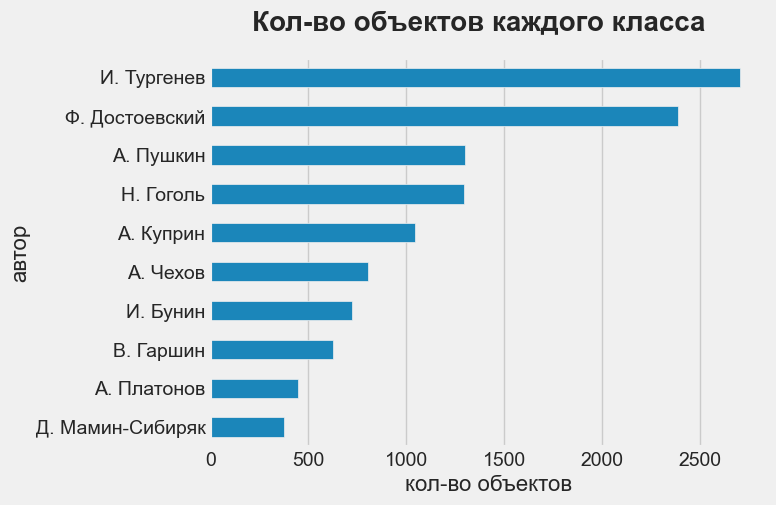

In [9]:
# вывод на экран графика количества объектов каждого класса
fig = plt.figure()

plt.suptitle('Кол-во объектов каждого класса',
             fontsize=20,
             fontweight='bold')

sns.countplot(df.sort_values(by='target'), 
              y='target', 
              order=df['target'].value_counts().index,
              width=0.5)

plt.xlabel('кол-во объектов', fontsize=16)
plt.ylabel('автор', fontsize=16)

plt.show()

Мы наблюдаем достаточно большой разброс в количестве объектов.

Хотя на этапе сбора данных мы отобрали по каждому автору одинаковое количество произведений:

- по по отдельным авторам в отобранные произведения попали сборники;
- на этапе предобработки мы разделили произведения на объекты фиксированной длины, и по авторам более коротких произведений (писавших произведения более короткого формата) получилось меньше объектов.

Для анализа частей речи выровняем количество объектов каждого класса для анализа путем даунсемплинга (по каждому автору возьмем количество объектов, равное самому маленькому количеству объектов по автору):

In [198]:
# даунсемплинг данных
df_sample = df.groupby('target').sample(df.target.value_counts().min(), random_state=RANDOM_STATE).reset_index(drop=True)

Проведем предобработку данных:
- переведем слова в нижний регистр
- удалим пунктуацию, http ссылки, цифры и символы перевода на новую строку

In [197]:
df_sample

,target,text,book
366,А. Куприн,глазами от глаз одного мужчины к глазам другог...,raw_data/aleksandr_kuprin_granatovyj_braslet.txt
323,А. Куприн,"Приметив , что у меня делается помрачение ума ...",raw_data/aleksandr_kuprin_granatovyj_braslet.txt
552,А. Куприн,годового дохода точно наэлектризовали все обще...,raw_data/aleksandr_kuprin_moloh.txt
97,А. Куприн,"он уже совсем перевесился через арку , держась...",raw_data/aleksandr_kuprin_belyj_pudel'.txt
1013,А. Куприн,"за тройками к Ечкину , скакали сломя голову за...",raw_data/aleksandr_kuprin_taper.txt
...,...,...,...
6043,Ф. Достоевский,никуда не будет годиться . Завтрашний день пре...,raw_data/fedor_dostoevskij_vechnyj_muzh.txt
4874,Ф. Достоевский,Веселая ? Я было не понял вопроса.— Не скучно ...,raw_data/fedor_dostoevskij_igrok.txt
5064,Ф. Достоевский,"дама , лет под тридцать , с каким-то болезненн...",raw_data/fedor_dostoevskij_igrok.txt
5520,Ф. Достоевский,обтирать ее салфеткой . Это последнее несчасть...,raw_data/fedor_dostoevskij_skvernyj_anekdot.txt


In [11]:
# предобработка текстов
df_sample_prep = df_sample['text'].apply(preprocess_text5)

In [12]:
# вывод на экран первых пяти объектов после предобработки
for text in df_sample_prep.head():
    print(f'{text}\n')

глазами от глаз одного мужчины к глазам другого и обратно приличная внешность обоих должно быть успокоила ее дома прошу сказала она открывая дверь первая дверь налево булат тугановский постучал три раза коротко и решительно какой то шорох послышался внутри он еще раз постучал войдите отозвался слабый голос комната была очень низка но очень широка и длинна почти квадратной формы два круглых окна совсем похожих на пароходные иллюминаторы еле еле ее освещали

приметив что у меня делается помрачение ума закричал чтобы подали мне воды помочил голову и рассудок мой воротился воображаю яков михайлович сколько вы там побед одержали над женщинами сказала пианистка женни рейтер вы должно быть смолоду очень красивы были о наш дедушка и теперь красавец воскликнула анна красавцем не был спокойно улыбаясь сказал аносов но и мной тоже не брезговали вот в этом же букаресте был очень трогательный случай когда мы в него вступили

годового дохода точно наэлектризовали все общество с блестящими глазами и 

Данные предобработаны, можно переходить к анализу

## Анализ статистик по частям речи

Посчитаем по каждому объекту количество слов каждой части речи:

In [13]:
#  создание словаря с возможными значениями частей речи и примерами слов
pos_dict = dict()
for text in df_sample_prep:
    for token in nlp(text):
        if token.pos_ not in pos_dict:
            pos_dict[token.pos_] = [token.text]
        elif len(pos_dict[token.pos_]) < 5 and token.text not in pos_dict[token.pos_]:
            pos_dict[token.pos_].append(token.text)

In [14]:
# вывод на экран списка найденных частей речи и примеров слов
for pos, examples in pos_dict.items():
    print(f'{pos} -> {examples}')

NOUN -> ['глазами', 'глаз', 'мужчины', 'глазам', 'внешность']
ADP -> ['от', 'к', 'на', 'у', 'над']
NUM -> ['одного', 'обоих', 'три', 'два', 'сколько']
ADJ -> ['другого', 'приличная', 'должно', 'первая', 'слабый']
CCONJ -> ['и', 'но', 'или', 'а', 'причем']
ADV -> ['обратно', 'дома', 'налево', 'коротко', 'решительно']
AUX -> ['быть', 'была', 'были', 'был', 'бы']
VERB -> ['успокоила', 'прошу', 'сказала', 'открывая', 'постучал']
PRON -> ['ее', 'она', 'он', 'меня', 'мне']
PROPN -> ['булат', 'тугановский', 'воображаю', 'яков', 'михайлович']
DET -> ['какой', 'мой', 'наш', 'этом', 'все']
SCONJ -> ['то', 'что', 'чтобы', 'когда', 'чем']
PART -> ['еле', 'не', 'вот', 'же', 'только']
X -> ['a', 'la', 'rule', 'britannia', 'l']
INTJ -> ['ха', 'ах']
PUNCT -> ['б', 'эй']


In [100]:
pos_dict.keys()

dict_keys(['NOUN', 'ADP', 'NUM', 'ADJ', 'CCONJ', 'ADV', 'AUX', 'VERB', 'PRON', 'PROPN', 'DET', 'SCONJ', 'PART', 'X', 'INTJ', 'PUNCT'])

In [139]:
# создание списка с переводом названий частей речи
pos_rus = [
    'существительное\n(нарицательное)',
    'предлог',
    'числительное',
    'прилагательное\n(порядковое\nчислительное)',
    'сочинительный\nсоюз',
    'наречие',
    'вспомогательный\nграмматический\nпоказатель',
    'глагол',
    'местоимение-\nсуществительное',
    'существительное\n(собственное)',
    'местоимение-\nприлагательное',
    'подчинительный\nсоюз',
    'частица',
    '???',
    'междометие',
    'пунктуация'
]

In [140]:
# создание словаря для перевода частей речи
pos2rus = dict(zip(pos_dict.keys(), pos_rus))

In [103]:
# создание списка для хранения статистик по частям речи по каждому объекту
pos_count = []

# по каждому объекту подсчет количества каждой части речи
for text in df_sample_prep:
    tpc = dict(zip(pos_dict.keys(), [0] * len(pos_dict)))
    for token in nlp(text):
        tpc[token.pos_] += 1
    pos_count.append([*tpc.values()])

In [16]:
# нормализуем количество частей речи по объекту и создадим датасет со статистиками по объекту по части речи
df_pos = pd.DataFrame(df_sample['target']).reset_index(drop=True).join(pd.DataFrame(normalize(pos_count, 'l1'), columns=pos_dict.keys()))

# вывод на экран первых пяти строк датафрейма
df_pos.head()

,target,NOUN,ADP,NUM,ADJ,CCONJ,ADV,AUX,VERB,PRON,PROPN,DET,SCONJ,PART,X,INTJ,PUNCT
0,А. Куприн,0.239437,0.042254,0.056338,0.154930,0.056338,0.154930,0.028169,0.126761,0.056338,0.028169,0.014085,0.014085,0.028169,0.0,0.0,0.0
1,А. Куприн,0.216216,0.067568,0.013514,0.027027,0.054054,0.081081,0.054054,0.175676,0.094595,0.081081,0.040541,0.040541,0.054054,0.0,0.0,0.0
2,А. Куприн,0.310811,0.094595,0.000000,0.094595,0.108108,0.094595,0.013514,0.148649,0.054054,0.013514,0.040541,0.013514,0.013514,0.0,0.0,0.0
3,А. Куприн,0.192771,0.084337,0.000000,0.024096,0.048193,0.168675,0.000000,0.204819,0.084337,0.012048,0.060241,0.048193,0.072289,0.0,0.0,0.0
4,А. Куприн,0.289855,0.144928,0.014493,0.115942,0.057971,0.115942,0.000000,0.101449,0.014493,0.043478,0.043478,0.028986,0.028986,0.0,0.0,0.0


In [131]:
# визуализация распределения долей частей речи в объектах
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(13,13))
axs = axs.flatten()

fig.suptitle('Распределение долей частей речи в объектах',
             fontsize=20,
             fontweight='bold')

for i, pos in enumerate(df_pos.columns[1:]):
    
    axs[i].set_title(pos2rus[pos], fontsize=16)
    if pos not in ['NUM', 'AUX', 'PROPN', 'SCONJ', 'X', 'PUNCT', 'INTJ', 'DET']:
        sns.kdeplot(df_pos[pos] * 100, ax=axs[i])
    else:
        sns.kdeplot(df_pos[pos] * 100, ax=axs[i], color='#E24A33')
    if (i + 3) % 4 == 0:
        axs[i].set_xlabel(' ' * 50 + 'доля части речи в объекте, %', fontsize=16)
    else:
        axs[i].set_xlabel(' ')
    if i % 4 == 0:
        axs[i].set_ylabel('плотность\nраспределения', fontsize=16)
    else:
        axs[i].set_ylabel(' ')
        
plt.tight_layout()
plt.show()

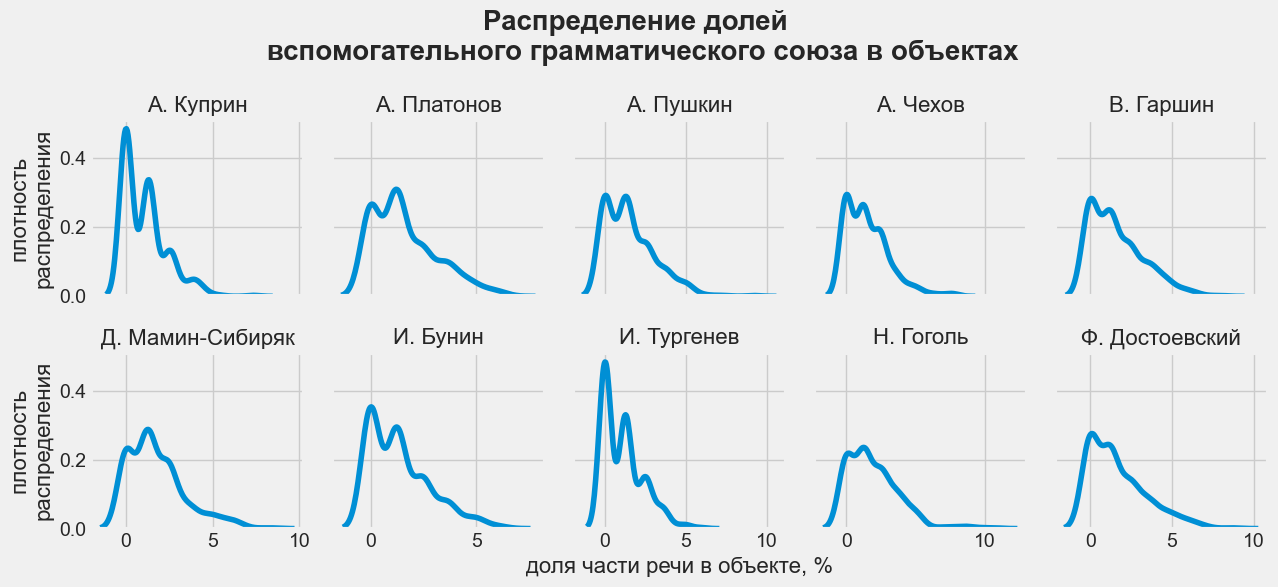

In [130]:
# визуализация распределения вспомогательного грамматического союза в объектах
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(13,6), sharey=True, sharex='col')
axs = axs.flatten()

fig.suptitle('Распределение долей \n вспомогательного грамматического союза в объектах',
             fontsize=20,
             fontweight='bold')

for i, author in enumerate(df_pos.target.unique()):

    axs[i].set_title(author, fontsize=16)
    sns.kdeplot(df_pos[df_pos.target ==author]['AUX'] * 100, ax=axs[i])
    axs[i].set_ylabel('плотность\nраспределения', fontsize=16)
    if i == 7:
        axs[i].set_xlabel('доля части речи в объекте, %', fontsize=16)
    else:
        axs[i].set_xlabel(' ')

plt.tight_layout()
plt.show()

Мы наблюдаем мультимодальное распределение по всем авторам.

Оставим только части речи, распределение долей которых в объектах близко к нормальному, для борьбы с выбросами в качестве аггрегирующей статистики используем медиану:

In [19]:
# сокращение количества признаков
df_pos_rem = df_pos.drop(columns=[
    'NUM', 'AUX', 'PROPN', 'SCONJ', 'X', 'PUNCT', 'INTJ', 'DET'
])

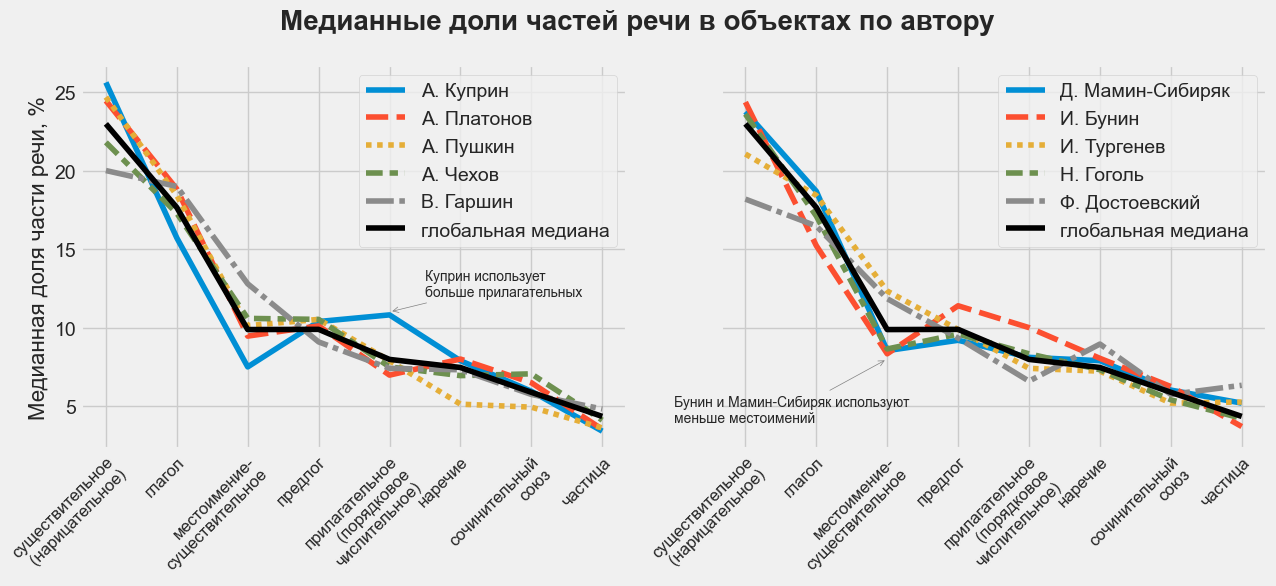

In [147]:
# визуализация средних долей частей речи в объектах по автору
sort_ind = df_pos_rem.groupby('target').mean().mean().sort_values(ascending=False).index

fig, axs = plt.subplots(ncols=2, figsize=(13,6), sharey=True)

fig.suptitle('Медианные доли частей речи в объектах по автору',
             fontsize=20,
             fontweight='bold')

sns.lineplot(df_pos_rem.groupby('target').median().iloc[:5,:][sort_ind].T * 100, ax=axs[0])
sns.lineplot(df_pos_rem.groupby('target').median().iloc[5:,:][sort_ind].T * 100, ax=axs[1])

for ax in axs:
    sns.lineplot(df_pos_rem.iloc[:, 1:].median()[sort_ind].T * 100, color='black', label='глобальная медиана', ax=ax)
    ax.set_xticks(ticks=df_pos_rem.columns[1:], labels=[pos2rus[pos] for pos in df_pos_rem.columns[1:]], fontsize=12, rotation=45, ha='right', rotation_mode='anchor')

axs[0].set_ylabel('Медианная доля части речи, %', fontsize=16)

axs[0].annotate("Куприн использует \nбольше прилагательных", xy=(4, 11), xytext=(4.5, 12), arrowprops={"arrowstyle":"->", "color":"gray"}, fontsize=10)
axs[1].annotate("Бунин и Мамин-Сибиряк используют \nменьше местоимений", xy=(2, 8), xytext=(-1, 4), arrowprops={"arrowstyle":"->", "color":"gray"}, fontsize=10)

plt.tight_layout()
plt.show()

Мы видим, что авторы различаются по медианной частоте использования частей речи:

- Куприн использует больше нарицательных и прилагательных, но меньше глаголов и местоимений;
- Пушкин использует меньше прилагательных и сочинительных союзов;
- Бунин использует больше нарицательных, прилагательных и предлогов, но меньше местоимений и глаголов;
- и т.д.

Попроубем понять, позволит ли это нам после понижения размерности разделить объекты авторов. Для улучшения качества работы алгоритмов понижения размерности:
- обрежем значения по 99 персентилю;
- стандартизируем данные.

In [99]:
# создание копии данных для понижения размерности
df_pos_reduce = df_pos_rem.iloc[:, 1:].copy()

In [70]:
# обрезание значений по 99 персентилю
replace = np.percentile(df_pos_reduce, 99, axis=0)
for i in range(df_pos_reduce.shape[1]):
    df_pos_reduce[df_pos_reduce.iloc[:,i] > replace[i]].iloc[:,i] = replace[i]

In [71]:
#стандартизация данных
scaler = StandardScaler()

df_pos_reduce_scaled = scaler.fit_transform(df_pos_reduce)

In [72]:
# создание объекта класса PCA
pca = PCA(n_components=2)

# понижение размерности данных при помощи PCA
pca_data = pd.DataFrame(pca.fit_transform(df_pos_reduce_scaled))

In [88]:
# создание объекта класса TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3)

# понижение размерности данных при помощи TSNE
tsne_data = tsne.fit_transform(df_pos_reduce_scaled)

In [90]:
# визуализация данных после понижения размерности
fig, axs = plt.subplots(ncols=2, figsize=(13,6))

fig.suptitle('Объекты после понижения размерности данных \n статистик по частям речи',
             fontsize=20,
             fontweight='bold')

axs[0].set_title('TSNE', fontsize=16)
sns.scatterplot(pd.DataFrame(tsne_data), x=0, y=1, hue=df_pos_rem.target, s=15, ax=axs[0])

axs[0].set_xlabel('')
axs[0].set_ylabel('')

axs[1].set_title('PCA', fontsize=16)
sns.scatterplot(pd.DataFrame(pca_data), x=0, y=1, hue=df_pos_rem.target, s=15, ax=axs[1])

axs[1].set_xlabel('первая главная компонента', fontsize=16)
axs[1].set_ylabel('вторая главная компонента', fontsize=16)

for ax in axs:
    ax.legend().set_visible(False)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels) // 2, frameon=False)

plt.tight_layout()
plt.show()

Понижение размерности не позволяет кластеризовать писателей на основании статистик по использованию частей речи.

## Тематическое моделирование

Для тематического моделирования используем существительные (нарицательные), прилагательные и глаголы. Тематическое моделирование будем проводить на несемплированных данных. Дополнительно лемматизируем тексты и удалим стоп-слова (в основном это мисклассифицированные существительные (собственные) и слова, не несущие самостоятельной тематической нагрузки).

Будем проводить тематическое моделирование при помощи алгоритма LFA. Создадим несколько моделей LDA в зависимости от количества тем (от 10 до 30 с шагом 5), и для оценки качества работы моделей будем использовать экспертную оценку на 10 случайных объектах.

In [295]:
# создание списка с частями речи для проведения тематического моделирования 
pos_to_use = ['NOUN', 'ADJ', 'VERB']

# создание списка стоп-слов
stopwords = [
    'антошка',
    'аркадий',
    'бухарбай',
    'быть',
    'еремка',
    'иван',
    'ивановна',
    'иваныч',
    'макар',
    'митя',
    'марья',
    'может',
    'мочь',
    'наташа',
    'нет',
    'петрович',
    'петрушка',
    'прошка',
    'раз',
    'сам',
    'сами',
    'самое',
    'самый',
    'сергеевна',
    'тарас',
    'фрося',
    'хотеть',
    'хотел'
]

In [296]:
df_prep = df['text'].apply(preprocess_text5)

In [297]:
# лемматизация и удаление стоп-слов
tokens = [
    [token.lemma_ for token in nlp(text) if token.pos_ in pos_to_use and token.lemma_ not in stopwords]
    for text in df_prep
]

In [298]:
# создание словаря слов
dictionary = corpora.Dictionary(tokens)

In [299]:
# фильтрация очень редких и очень частых слов, ограничение размера словаря
dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=5000)

In [300]:
corpus = [dictionary.doc2bow(text) for text in tokens]

In [301]:
tfidf = models.TfidfModel(corpus) 

In [302]:
corpus_tfidf = tfidf[corpus]

In [303]:
# cемплирование текстов для оценки качества LDA-моделей
topic_modeling_sample = df_prep.sample(10, random_state=RANDOM_STATE)

In [304]:
# создание словаря для хранения обученных LDA-моделей
lda_models = dict()

# обучение LDA-моделей в зависимоти от количества тем
for n_topics in range(10, 31, 5):
    model = models.LdaModel(corpus, id2word=dictionary, num_topics=n_topics, random_state=RANDOM_STATE, passes=10)
    lda_models[f'lda_model_{n_topics}'] = model

In [305]:
# для каждого из объектов предсказание каждой LDA-моделью темы и вывод на экран вероятности темы и ключевых слов темы
for i, ind in enumerate(topic_modeling_sample.index, 1):
    print(f'sample {i}\n')
    text = df.loc[ind, 'text']
    print(f'{text}\n')
    
    for model_name, model in lda_models.items():
        topic_n, probability = sorted(model.get_document_topics(corpus[ind]), key=lambda x: x[1], reverse=True)[0]
        print(f'- model w {model_name[-2:]} topics -> topic {topic_n} with probability {str(np.round(probability, 2))[:5]} and words:{model.print_topic(topic_n, 5)}')
    print()      

sample 1

через ржаное поле , зашла в высокую , густую рожь , поросшую полынью и васильками , чтобы только не попасться ему на глаза . Он увидал ее головку сквозь золотую сетку колосьев , откуда она высматривала , как зверок , и ласково крикнул ей : — Здравствуй , Фенечка ! Я не кусаюсь.— Здравствуйте , — прошептала она , не выходя из своей засады.Понемногу она стала привыкать к нему , но все еще робела в его присутствии , как вдруг ее мать Арина умерла от холеры . Куда было деваться Фенечке ? Она наследовала от своей матери любовь к порядку ,

- model w 10 topics -> topic 9 with probability 0.41 and words:0.025*"сказать" + 0.023*"говорить" + 0.018*"знать" + 0.015*"спросить" + 0.012*"глаз"
- model w 15 topics -> topic 10 with probability 0.32 and words:0.015*"чёрный" + 0.014*"белый" + 0.012*"высокий" + 0.011*"нога" + 0.010*"длинный"
- model w 20 topics -> topic 10 with probability 0.2 and words:0.048*"казак" + 0.015*"голова" + 0.011*"высокий" + 0.009*"нога" + 0.008*"взять"
- model w 25

- все модели неплохо определяют темы, связанные с диалогами;
- модель с 10 темами также смогла определить тему, связанную с любовью (пример 2);
- модель с 15 темами также смогла определить темы, связанные с письмом (пример 6) и лошадьми (пример 5)
- модель с 20 и темами также смогла определить темы, связанные с действиями внутри помещений (пример 3) и лошадьми (пример 5)